# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Conv1D, Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.676'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [4]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

# train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
# dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
# test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
# train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
# dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
# test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10)
dev_X shape (69, 120, 25)
dev_y shape (69, 10)
test_X shape (35, 120, 25)
test_y shape (35, 10)
train_y_acc shape (585, 10)
dev_y_acc shape (69, 10)
test_y_acc shape (35, 10)


In [7]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.3
epochs = 1000
batch_size = 32

model = Sequential()
model.add(
    CuDNNLSTM(
        100,
        input_shape=input_shape,
        return_sequences=True,
    )
)
model.add(Dropout(dropout_rate))

model.add(CuDNNLSTM(100, return_sequences=True))
model.add(Dropout(dropout_rate))

model.add(CuDNNLSTM(100))
model.add(Dropout(dropout_rate))

model.add(Dense(100, activation="relu"))
model.add(Dropout(dropout_rate))

model.add(Dense(num_out, activation="linear"))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mse", optimizer=opt)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_4 (CuDNNLSTM)     (None, 120, 100)          50800     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
cu_dnnlstm_5 (CuDNNLSTM)     (None, 120, 100)          80800     
_________________________________________________________________
dropout_6 (Dropout)          (None, 120, 100)          0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 100)               80800     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
__________

In [8]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 3s 6ms/step - loss: 0.0496 - val_loss: 0.0218
Epoch 2/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0193 - val_loss: 0.0114
Epoch 3/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0143 - val_loss: 0.0082
Epoch 4/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0121 - val_loss: 0.0100
Epoch 5/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0121 - val_loss: 0.0082
Epoch 6/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0105 - val_loss: 0.0060
Epoch 7/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0096 - val_loss: 0.0044
Epoch 8/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0097 - val_loss: 0.0049
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 78/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 79/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 80/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 81/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 82/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 83/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 84/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 85/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 86/1000
585/585 [==============================] - 2s 3ms/step - lo

585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 6.8028e-04
Epoch 232/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 233/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 7.5037e-04
Epoch 234/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 7.2138e-04
Epoch 235/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 8.6100e-04
Epoch 236/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0014 - val_loss: 8.1428e-04
Epoch 237/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0014 - val_loss: 7.3444e-04
Epoch 238/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0013 - val_loss: 8.3874e-04
Epoch 239/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 6.8888e-04
Epoch 240/1000
585/585 [=======================

585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 6.2538e-04
Epoch 384/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 6.3852e-04
Epoch 385/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 7.3882e-04
Epoch 386/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 5.3205e-04
Epoch 387/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 6.7111e-04
Epoch 388/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 5.3097e-04
Epoch 389/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 8.4820e-04
Epoch 390/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 6.5388e-04
Epoch 391/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 6.2789e-04
Epoch 392/1000
585/585 [===================

Epoch 459/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 6.4855e-04
Epoch 460/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 4.7736e-04
Epoch 461/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.7847e-04 - val_loss: 7.3651e-04
Epoch 462/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 5.1849e-04
Epoch 463/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 4.9718e-04
Epoch 464/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 9.3206e-04
Epoch 465/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 5.5998e-04
Epoch 466/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 5.5019e-04
Epoch 467/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 6.3957e-04
Epoch 468/1000
585/585 [

585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 4.8077e-04
Epoch 610/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.6408e-04 - val_loss: 0.0011
Epoch 611/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.8794e-04 - val_loss: 4.8400e-04
Epoch 612/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.3048e-04 - val_loss: 4.2860e-04
Epoch 613/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.6870e-04 - val_loss: 7.4420e-04
Epoch 614/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.4923e-04 - val_loss: 5.1925e-04
Epoch 615/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.5523e-04 - val_loss: 6.1976e-04
Epoch 616/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.1222e-04 - val_loss: 5.1146e-04
Epoch 617/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 6.2768e-04
Epoch 618/1000
585/

585/585 [==============================] - 2s 3ms/step - loss: 9.3382e-04 - val_loss: 5.2839e-04
Epoch 758/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.5677e-04 - val_loss: 4.6964e-04
Epoch 759/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 9.8692e-04
Epoch 760/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.9993e-04 - val_loss: 4.5138e-04
Epoch 761/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.2552e-04 - val_loss: 4.9203e-04
Epoch 762/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.8261e-04 - val_loss: 5.2164e-04
Epoch 763/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.9615e-04 - val_loss: 4.3605e-04
Epoch 764/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.5547e-04 - val_loss: 5.0342e-04
Epoch 765/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.6538e-04 - val_loss: 5.2493e-04
Epoch 766/1

Epoch 905/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.5329e-04 - val_loss: 4.9071e-04
Epoch 906/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.3119e-04 - val_loss: 4.8267e-04
Epoch 907/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.5466e-04 - val_loss: 5.4580e-04
Epoch 908/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.9825e-04 - val_loss: 6.3608e-04
Epoch 909/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 7.0317e-04
Epoch 910/1000
585/585 [==============================] - 2s 3ms/step - loss: 8.5323e-04 - val_loss: 5.9052e-04
Epoch 911/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0010 - val_loss: 6.2908e-04
Epoch 912/1000
585/585 [==============================] - 2s 3ms/step - loss: 0.0011 - val_loss: 5.0216e-04
Epoch 913/1000
585/585 [==============================] - 2s 3ms/step - loss: 9.1228e-04 - val_loss: 4.6364e-04
Epoc

In [9]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.00033860905143513536
MSE Dev: 0.0005386180849075591
MSE Test: 0.0003708592194079225
MAE Train: 0.012414085515811525
MAE Dev: 0.015161586213302007
MAE Test: 0.015525276378798337


In [10]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

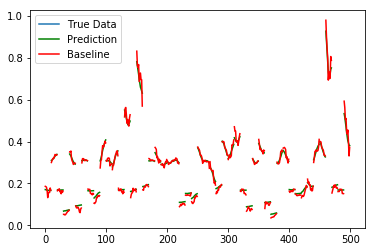

In [11]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

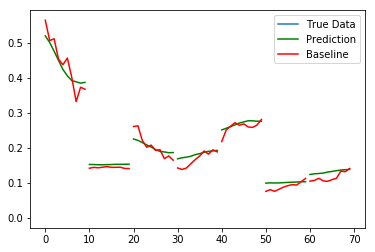

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.00036799650604616194
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.00036799650604616194


In [12]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

In [14]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

NameError: name 'model' is not defined

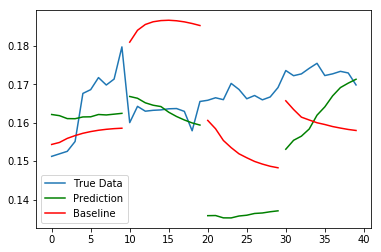

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.013370993975251582
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.0003071446230286893


In [14]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



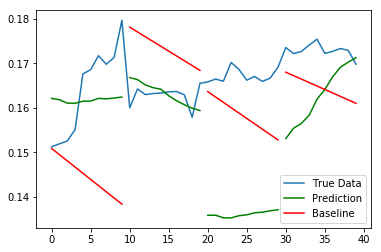

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.013370993975251582
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.0003071446230286893


In [15]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

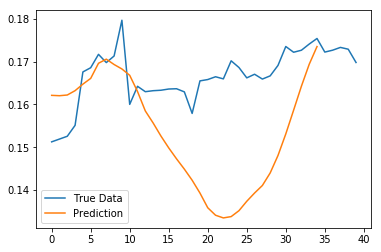

In [16]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)

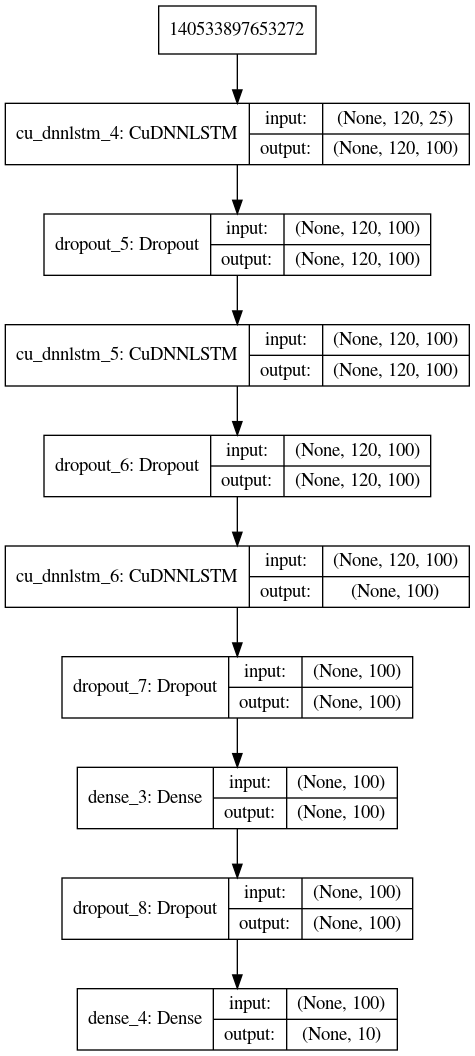

In [17]:
from IPython.display import SVG, Image, display
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_plot.png'))

VAR MAE Test: 0.036224475612312096
VAR MSE Test: 0.005257456151300216
(585, 10)


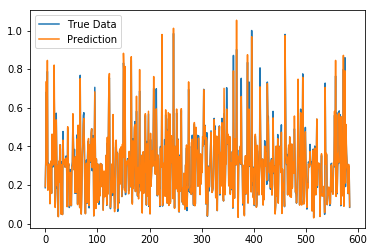

In [20]:
var_preds = utils.var_predict(train_X[:, :, 0:5], num_out)
print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), train_y.reshape(-1,1)))
print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), train_y.reshape(-1,1)))

In [7]:
var_preds = utils.var_predict(dev_X[:, :, 0:5], num_out)

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), dev_y.reshape(-1,1)))
print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), dev_y.reshape(-1,1)))

VAR MAE Test: 0.04418280130011637
VAR MSE Test: 0.007350277120852241


In [11]:
arima_preds = utils.arima_predict(train_X[:, :, 0], num_out)

print("VAR MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), train_y.reshape(-1,1)))
print("VAR MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), train_y.reshape(-1,1)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum L

VAR MAE Test: 0.03200257716714985
VAR MSE Test: 0.00300768367793862


In [12]:
arima_preds = utils.arima_predict(dev_X[:, :, 0], num_out)

print("VAR MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), dev_y.reshape(-1,1)))
print("VAR MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), dev_y.reshape(-1,1)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


VAR MAE Test: 0.03821086425854994
VAR MSE Test: 0.004103819308486988


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


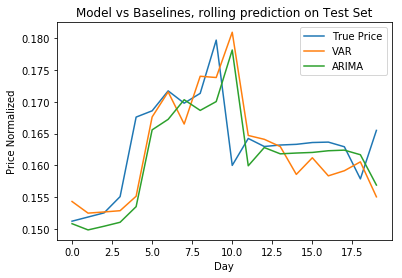

In [28]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
true_test = test_y[::num_out]

plt.plot(test_y[:2*num_out, 0], label='True Price')
plt.plot(var_preds[:2*num_out, 0], label='VAR')
plt.plot(arima_preds[:2*num_out, 0], label='ARIMA')
plt.xlabel('Day')
plt.ylabel('Price Normalized')
plt.title('Model vs Baselines, rolling prediction on Test Set')
plt.legend()
plt.show()


# utils.plot_results(var_preds[:, 0], test_y[:,0])